# 4.0 Training and testing

Here we create a manual rune classifier using our 2 cleaned features: `num of regions` and `sum of black pixels`.

### 1. Adding the libraries we need

In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

### 2. Read in the feature dataset from the result of 3.0 notebook

In [2]:
directory = "../dataset-numpy/"

dataset = pd.read_csv(os.path.join(directory, '3.0 - features.csv'), delimiter=',', header=0)

dataset.describe(include='all')

,label,black_pixels,regions
count,1366,1366.000000,1366.000000
unique,12,NaN,NaN
top,ash,NaN,NaN
freq,154,NaN,NaN
mean,NaN,2684.899707,1.351391
std,NaN,842.105852,0.633227
min,NaN,810.000000,1.000000
25%,NaN,2108.000000,1.000000
50%,NaN,2484.500000,1.000000
75%,NaN,3099.000000,2.000000


### 3. Create training and testing datasets

We will use the `train_test_split` function from `sklearn` to split the dataset into training and testing datasets. We will use 75% of the data for training and 25% for testing.

In [3]:
X = dataset.loc[:, dataset.columns != 'label']
y = dataset.loc[:, dataset.columns == 'label']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42) # 42 for random state so we always get the same split

### 4. Creating the model

Here we create our manual classifier. It is a Python class with 2 functions: `classify` - predicts a label, and `accuracy` - calculates model accuracy based on the provided testing and training dataset provided in the constructor.

Our model classifies runes in the following way:

1. First we provide the model a training dataset. This creates a lookup dictionary for our model, where the model can fetch a label based on the 2 given features.
2. When we classify, we first filter images in our lookup dictionary where based on the region count.
3. If we have an empty lookup table, that means we have a region count for which the model does not have a label. In this case we use all entries in the lookup table.
4. After we have our filtered image lookup set, we find the closest entry based on black pixel count. That entry's label will be our prediction.

In [4]:
class RuneClassifier:
    """Manual Rune Classifier

    This classifier uses the sum of black pixels and the count of regions to predict a rune

    The `training_set` and `testing_set` contains the 2 features, and the `training_labels` and `testing_labels` contain only 1 column, the labels.
    The 2 testing variables are required for calculating the accuracy.
    """
    def __init__(self, training_set, training_labels, testing_set, testing_labels):
        self.training_set = training_set
        self.training_labels = training_labels
        self.testing_set = testing_set
        self.testing_labels = testing_labels

        # for each unique label entry in training_labels, we have a dictionary of features with the value of 0
        self.model = {label: {feature: 0 for feature in training_set.columns} for label in training_labels['label'].unique()}

        # for each unique label entry in training_labels, we average the values of each feature in training_set and put it in the model
        for label in self.model.keys():
            self.model[label] = round(self.training_set[self.training_labels['label'] == label].mean(axis=0))

    def classify(self, input):
        """Based on the `input`, predict what the rune might be.

        The `input` is a tuple, where the first value is the sum of black pixels (int) and the second value is the count of regions (int)

        Example: (12345, 5)

        Returns: The name of the predicted rune (String)
        """
        black_pixels, regions = input

        # filter out items in model where regions do not equal to the regions in the input
        filtered_model = {k: v for k, v in self.model.items() if v['regions'] == regions}

        if len(filtered_model) == 0: # we check if we have no match for region count.
            filtered_model = self.model # if we have no match, we just use the whole training set for black pixel distance counting

        best_match_label = None
        best_distance = float('inf') # we only want the lowest number, so we set the highest possible as base

        # we try to find the closest match with black pixels, after we filtered our dataset based on the region count
        for label, values  in filtered_model.items():
            distance = abs(values['black_pixels'] - black_pixels)
            if distance < best_distance: # we try to find the closest match
                best_distance = distance
                best_match_label = label

        return best_match_label

    def accuracy(self):
        """Calculate the accuracy of the model

        Returns: float between 0 and 1, where 1 means 100% accuracy (all images were classified correctly)
        """
        correct = 0
        for index, row in enumerate(self.testing_set.values):
            black_pixels, regions = row
            prediction = self.classify((black_pixels, regions))
            expected = self.testing_labels.values[index][0]
            if prediction == expected:
                correct += 1

        return correct / len(self.testing_set)


### 5. Fitting the model

Here we give the training and testing dataset to our model to fit (train) it. We then attempt to predict a rune.

In [5]:
model = RuneClassifier(training_set=X_train, training_labels=y_train, testing_set=X_test, testing_labels=y_test)

print(model.classify((4801, 3))) # we expect spear

spear


### 6. Testing the model's accuracy

We now print the accuracy of our model

In [6]:
print(model.accuracy())

0.38011695906432746


As we can see, our manual model is 38% accurate. This is because we only used 2 features, and 1 feature (count of regions) was always the same per category (overfitted)

We also print the confusion matrix to see which images cased our model to be less accurate

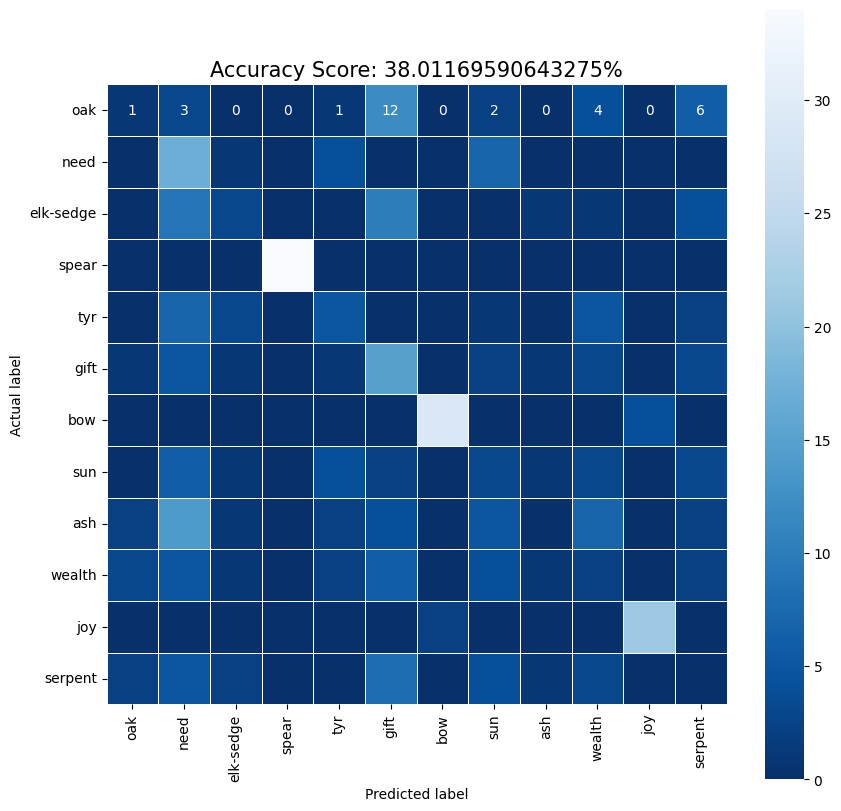

In [7]:
labels = ['oak', 'need', 'elk-sedge', 'spear', 'tyr', 'gift', 'bow', 'sun', 'ash', 'wealth', 'joy', 'serpent']

y_pred = []

for _, row in X_test.iterrows():
    black_pixels = row['black_pixels']
    regions = row['regions']
    y_pred.append(model.classify((black_pixels, regions)))

cm = confusion_matrix(y_test, y_pred, labels=labels)

score = accuracy_score(y_test, y_pred)*100

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues_r', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}%'.format(score), size=15)
plt.show()

We can see that our model could accurately predict `spear`, `bow` and `joy`. However, it had a lot of confusion for `ash` - `need`, `elk sedge` - `need`, etc. It seems, the model confused a lot of images with `need`, and it had troubles predicting `elk sedge` and `serpent`.

### 7. Save the model

Using the Pickle library, we serialize our model into a binary file, so later on we can reuse it.

In [8]:
directory = "../classifiers/" 
path = os.path.join(directory, '4.0 - manual model.pkl')

with open(path, 'wb') as file:
    pickle.dump(model, file)